In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

from mlxtend.regressor import StackingCVRegressor

import skopt
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import EarlyStopper, DeltaYStopper

import optuna
from optuna.visualization import plot_intermediate_values


import warnings
warnings.filterwarnings('ignore')

import time
%matplotlib inline

In [2]:
df_ = pd.read_csv('./data/train_df_step1.csv', index_col='Id')
df_t_= pd.read_csv('./data/test_df_step1.csv', index_col='Id')


In [3]:
# np.exp(df_['SalePrice_log'])

In [4]:
df_.shape, df_t_.shape

((1252, 87), (1459, 86))

In [5]:
df_t_.isna().sum().sum()

0

In [6]:
nominal = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional',
       'GarageType', 'SaleType', 'SaleCondition',
       'Street', 'CentralAir', 'RenovatedY/N', '2ndFloorY/N', 'PorchY/N',
       'BsmtFinSF2_cat', 'LowQualFinSF_cat', 'EnclosedPorch_cat',
       '3SsnPorch_cat', 'ScreenPorch_cat', 'MiscVal_cat', 'PoolArea_cat']

ordinal = ['MSSubClass', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'YrSold', 'AgeWhenSold', 'totBath', 'OtherRooms']

continuous = ['2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
       'GarageSpaceForCar', 'MasVnrArea', 'MoSold_cos', 'MoSold_sin',
       'OpenPorchSF', 'TotalBsmtFinSF', 'TotalBsmtSF', 'TotalPorchSF',
       'WoodDeckOpenPorch', 'WoodDeckSF', '1stFlrSF_log',
       'AverageRoomSF_log', 'GrLivArea_log', 'LotArea_log',
       'SalePrice_log', 'totSqFt_log']

## Standartization

In [7]:
# def standartize(df, columns):
#     st_df = df.copy()
    
#     scaler = StandardScaler()
    
#     st_df[columns] = scaler.fit_transform(df[columns])
#     print(df.shape, st_df.shape)
    
#     return st_df

In [8]:
# st_train_df = standartize(df_, ordinal + continuous)

# arr_to_standartize_test = ordinal + continuous
# arr_to_standartize_test.remove('SalePrice_log')
# st_test_df = standartize(df_t_, arr_to_standartize_test)

## OHE

In [9]:
def one_hot_enc(train_df, test_df, columns):
    train_df['Status'] = 'Train'
    test_df['Status'] = 'Test'
    
    app_df = train_df.append(test_df)
    
    merded_app_df = pd.concat([pd.get_dummies(app_df[columns], drop_first=True), 
                           app_df.loc[:, app_df.columns[~app_df.columns.isin(columns)]]], axis=1)
    
    train_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Train']
    train_df_enc.drop('Status', axis=1, inplace=True)

    test_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Test']
    test_df_enc.drop(['Status', 'SalePrice_log'], axis=1, inplace=True)


    print(train_df_enc.shape, test_df_enc.shape)
    
    return train_df_enc, test_df_enc

In [10]:
train_df, test_df = one_hot_enc(df_, df_t_, nominal)

(1252, 207) (1459, 206)


In [11]:
# len(ordinal + continuous), len(train_df.columns[~train_df.columns.isin(nominal)]) - 1 # minus Status

## Drop highly correlated features (from initial df)

In [12]:
serial_corr_cols_to_drop = ['YrSold', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea_log', 'BsmtFinSF2_cat',
        '1stFlrSF_log', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BsmtFinSF1', 'BsmtFinSF2_cat', 'BsmtFinSF', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch_cat',
        '3SsnPorch_cat', 'PoolArea_cat', 'RoofStyle', 'RoofMatl', 'Condition2', 'BsmtFinType1', 'LandSlope', 'Exterior2nd']

In [13]:
train_df1 = df_.copy()
test_df1 = df_t_.copy()


train_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)
test_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)

nominal1 = list(set(nominal) - set(serial_corr_cols_to_drop))
ordinal1 = list(set(ordinal) - set(serial_corr_cols_to_drop))
continuous1 = list(set(continuous) - set(serial_corr_cols_to_drop))


In [14]:
# st_train_df1 = standartize(train_df1, ordinal1 + continuous1)

# arr_to_standartize_test1 = ordinal1 + continuous1
# arr_to_standartize_test1.remove('SalePrice_log')
# st_test_df1 = standartize(test_df1, arr_to_standartize_test1)

In [15]:
# train_df1, test_df1 = one_hot_enc(st_train_df1, st_test_df1, nominal1)

## Modelling

In [16]:
X = train_df.drop('SalePrice_log', axis=1)
y = train_df['SalePrice_log']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

X1 = train_df1.drop('SalePrice_log', axis=1)
y1 = train_df1['SalePrice_log']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, shuffle=True, test_size=0.2)

kfolds = KFold(n_splits=6, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y, kfolds=kfolds, verb=0):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds, n_jobs=3, verbose=verb))
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kfolds, n_jobs=3, verbose=verb)
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kfolds, n_jobs=3, verbose=verb)
    return rmse, mae, r2

def display_cv_scores(rmse_, mae_, r2_):
    print(f'RMSE CV: {rmse_}  Mean RMSE: {round(rmse_.mean(),7)} Std RMSE: {round(rmse_.std(),7)}')
    print(f'MAE CV: {mae_}  Mean MAE: {round(mae_.mean(),7)} Std MAE: {round(mae_.std(),7)}')
    print(f'R2 CV: {r2_}  Mean R2: {round(r2_.mean(),7)} Std R2: {round(r2_.std(),7)}')

## Tune hyperparameters

### Base models

#### Lasso

In [242]:
alpha_l1_ = np.linspace(5e-5, 0.005, 100)
lasso_reg = make_pipeline(StandardScaler(), LassoCV(alphas=alpha_l1_, cv=kfolds)).fit(X, y)


R2:  0.9236969945996113 ;    Chosen alpha:  0.00425


In [245]:
print('R2: ', lasso_reg.score(X, y), ';    Chosen alpha: ', lasso_reg['lassocv'].alpha_, '\n')
display_cv_scores(*cv_rmse(lasso_reg, X, y))

R2:  0.9236969945996113 ;    Chosen alpha:  0.00425 

RMSE CV: [0.10519479 0.10411018 0.11102686 0.11221522 0.11366421 0.10834103]  Mean RMSE: 0.109092 Std RMSE: 0.0035349
MAE CV: [0.07194258 0.07674082 0.07418539 0.07513466 0.08036307 0.0726557 ]  Mean MAE: 0.0751704 Std MAE: 0.0028031
R2 CV: [0.90198627 0.92426808 0.90084777 0.89919423 0.9045292  0.90230187]  Mean R2: 0.9055212 Std R2: 0.0085358


#### Ridge

In [309]:
alpha_l2_ = np.linspace(285, 298, 30)
ridge_reg = make_pipeline(StandardScaler(), RidgeCV(alphas=alpha_l2_, cv=kfolds)).fit(X, y)


In [310]:
print('R2: ', ridge_reg.score(X, y), ';    Chosen alpha: ', ridge_reg['ridgecv'].alpha_)
display_cv_scores(*cv_rmse(ridge_reg, X, y))

R2:  0.9299019266367227 ;    Chosen alpha:  287.2413793103448
RMSE CV: [0.10608669 0.10403983 0.11818039 0.1166861  0.11570501 0.11237125]  Mean RMSE: 0.1121782 Std RMSE: 0.0053567
MAE CV: [0.07373466 0.07796489 0.07964197 0.07561017 0.08270633 0.07525832]  Mean MAE: 0.0774861 Std MAE: 0.0030189
R2 CV: [0.9003172  0.9243704  0.88765927 0.8910016  0.90107013 0.89489806]  Mean R2: 0.8998861 Std R2: 0.011933


#### ElasticNet

In [327]:
elastic_alpha = np.linspace(0., 0.5, 20)
l1_ratio = np.linspace(0, 0.2, 20)

elnet_regr = make_pipeline(StandardScaler(), ElasticNetCV(l1_ratio=l1_ratio, alphas=elastic_alpha, cv=kfolds)).fit(X, y)


In [329]:
elnet_name = 'elasticnetcv'
print(f'R2: {elnet_regr.score(X, y):.5f};    Chosen alpha: {elnet_regr[elnet_name].alpha_:.5f};  Chosen l1_ratio: {elnet_regr[elnet_name].l1_ratio_:.5f}')
display_cv_scores(*cv_rmse(elnet_regr, X, y))

R2: 0.92522;    Chosen alpha: 0.07895;  Chosen l1_ratio: 0.04211
RMSE CV: [0.10403714 0.10256335 0.11234602 0.11146286 0.11375133 0.1088138 ]  Mean RMSE: 0.1088291 Std RMSE: 0.0041983
MAE CV: [0.07195454 0.07646166 0.07530266 0.07438065 0.0802521  0.07279407]  Mean MAE: 0.0751909 Std MAE: 0.0027117
R2 CV: [0.90413166 0.92650175 0.89847762 0.90054142 0.9043828  0.90144737]  Mean R2: 0.9059138 Std R2: 0.0094295


In [18]:
# poly_X1 = PolynomialFeatures(degree=2).fit_transform(X1)
# lin_reg = LinearRegression().fit(poly_X1, y1)
# print('R2: ', lin_reg.score(poly_X1, y1))

In [19]:
# lin_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# # print('R2: ', lin_reg.score(X1, y))
# lin_reg.fit(X1, y)

In [20]:
# display_cv_scores(*cv_rmse(lin_reg, X1, y, kfolds=kfolds))

#### SVR

In [330]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [337]:
param_svr = [{'svr__kernel': ['rbf'], 'svr__gamma': [1e-2, 1e-3, 1e-4],
                     'svr__C': np.arange(0, 9, 2)},
             {'svr__kernel': ['linear'], 'svr__C': np.arange(0, 9, 2)},
             {'svr__kernel': ['poly'], 'svr__degree': [1, 2, 3], 'svr__C': np.arange(0, 9, 2)}
            ]

svr_reg = make_pipeline(StandardScaler(), SVR())

gridsearchsvr = GridSearchCV(estimator=svr_reg,
                      param_grid= param_svr,
                      scoring='neg_mean_squared_error',
                      cv=kfolds,
                      n_jobs=3,
                            verbose=2)

gridsearchsvr = gridsearchsvr.fit(X, y)


Fitting 6 folds for each of 35 candidates, totalling 210 fits


In [338]:
gridsearchsvr.best_params_, -gridsearchsvr.best_score_

({'svr__C': 8, 'svr__gamma': 0.0001, 'svr__kernel': 'rbf'},
 0.012533148741541489)

In [359]:
tuned_param_svr = {
    'C': 9, 
    'gamma': 0.0001, 
    'kernel': 'rbf'
}

In [360]:
svr_reg = make_pipeline(StandardScaler(), SVR(**tuned_param_svr))

In [361]:
display_cv_scores(*cv_rmse(svr_reg, X, y))

RMSE CV: [0.10738722 0.10242739 0.11726213 0.11869506 0.11455692 0.11047128]  Mean RMSE: 0.1118 Std RMSE: 0.0056871
MAE CV: [0.07446898 0.07774235 0.07914101 0.07979823 0.08230895 0.07649253]  Mean MAE: 0.0783253 Std MAE: 0.0024925
R2 CV: [0.89785818 0.92669649 0.88939826 0.88721609 0.90302367 0.89842214]  Mean R2: 0.9004358 Std R2: 0.0129332


#### XGB Regressor

##### Bayes

In [27]:
%%time

xgbr_params = {
    
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),        
    'n_estimators': Integer(300, 1000, prior='uniform'),
    'subsample':  Real(0.5, 1., prior='uniform'),   
    'max_depth': Integer(3, 10, prior='uniform'),
    'min_child_weight': Integer(1, 9, prior='uniform'),
    # 'gamma': Real(0., 5,  prior='uniform'),
    # 'max_delta_step': Integer(0, 5, prior='uniform'),
    'colsample_bytree': Real(0.5, 1.,  prior='uniform'),
    'reg_alpha': Real(0., 6., prior='uniform'),
    'reg_lambda': Real(0., 6.)

}

search_xgbr = skopt.BayesSearchCV(estimator=xgb.XGBRegressor(),
                                search_spaces=xgbr_params,
                                scoring='neg_mean_squared_error',
                                n_iter=150,
                                cv=kfolds,
                                random_state=11,
                                n_jobs=3,
                                 verbose=10
                                )

search_xgbr_ = search_xgbr.fit(X, y, callback=DeltaYStopper(delta=1e-3, n_best=20)) #, callback=DeltaYStopper(delta=1e-3, n_best=3))

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Wall time: 55min 29s


In [28]:
-search_xgbr.best_score_, np.sqrt(-search_xgbr.best_score_)

(0.012262348819616293, 0.11073549033447358)

In [29]:
dict(search_xgbr.best_params_)

{'colsample_bytree': 0.5,
 'learning_rate': 0.01912052605367702,
 'max_depth': 3,
 'min_child_weight': 9,
 'n_estimators': 919,
 'reg_alpha': 0.0,
 'reg_lambda': 6.0,
 'subsample': 0.5}

##### Optuna (from colab)

optuna.visualization.matplotlib.plot_optimization_history(study_xgbr);

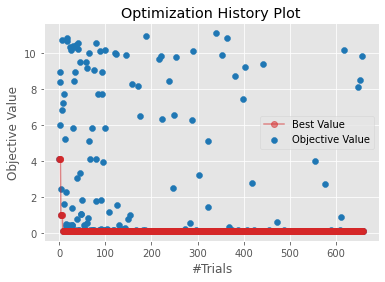

study_xgbr.best_value, study_xgbr.best_params

In [392]:
0.10925154931266658,
 {'colsample_bytree': 0.2,
  'learning_rate': 0.07003012284492525,
  'max_depth': 2,
  'min_child_weight': 9,
  'n_estimators': 575,
  'reg_alpha': 0.316,
  'reg_lambda': 1.213,
  'subsample': 0.9}

In [37]:
%%time

params_xgbr_bayes = {
     'colsample_bytree': 0.5,
     'learning_rate': 0.01912052605367702,
     'max_depth': 3,
     'min_child_weight': 9,
     'n_estimators': 919,
     'reg_alpha': 0.0,
     'reg_lambda': 6.0,
     'subsample': 0.5
}


params_xgbr_optuna = {
      'colsample_bytree': 0.2,
      'learning_rate': 0.07,
      'max_depth': 2,
      'min_child_weight': 9,
      'n_estimators': 575,
      'reg_alpha': 0.316,
      'reg_lambda': 1.213,
      'subsample': 0.9
}


tuned_xgbr_booster_bayes = xgb.XGBRegressor(**params_xgbr_bayes, eval_metric='rmse', n_jobs=4)

tuned_xgbr_booster_optuna = xgb.XGBRegressor(**params_xgbr_optuna, eval_metric='rmse', n_jobs=4)

print('Tuned by Bayes\n')
display_cv_scores(*cv_rmse(tuned_xgbr_booster_bayes, X, y))

print('\n\nTuned by Optuna\n')
display_cv_scores(*cv_rmse(tuned_xgbr_booster_optuna, X, y))

Tuned by Bayes

RMSE CV: [0.10923552 0.10243547 0.11756539 0.11010914 0.1155702  0.10884189]  Mean RMSE: 0.1106263 Std RMSE: 0.0049171
MAE CV: [0.07522502 0.0746369  0.07958483 0.07573385 0.08056594 0.07560789]  Mean MAE: 0.0768924 Std MAE: 0.0022951
R2 CV: [0.89431188 0.92668492 0.88882546 0.90294262 0.90130054 0.90139648]  Mean R2: 0.902577 Std R2: 0.0118446


Tuned by Optuna

RMSE CV: [0.10942958 0.10097091 0.1149508  0.11307088 0.11240219 0.10819424]  Mean RMSE: 0.1098364 Std RMSE: 0.0045582
MAE CV: [0.07577498 0.0754382  0.07770195 0.07741635 0.07777652 0.07485698]  Mean MAE: 0.0764942 Std MAE: 0.0011738
R2 CV: [0.89393604 0.92876637 0.8937154  0.89765105 0.90663747 0.90256645]  Mean R2: 0.9038788 Std R2: 0.0120393
Wall time: 55.3 s


#### LightGBM Regressor

In [20]:
%%time
# https://neptune.ai/blog/lightgbm-parameters-guide



lgbm_params = {
    'n_estimators': Integer(100, 4000),
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),
    'num_leaves': Integer(4, 12),
    'max_depth': Integer(2, 10),
    'min_split_gain': Real(0., 4.),
    # 'min_child_weight': Real(1e-4, 1e-2),
    'min_child_samples':  Integer(8, 30),
    'reg_alpha': Real(0., 5.),
    'reg_lambda': Real(0., 5.),
    'subsample': Real(0.5, 1.),
    # 'subsample_freq' : Integer(2,12)
  
    'min_split_gain': Real(0., 1.),\
    # 'max_bin': Integer(5, 50),
    # 'bagging_seed': Integer(2,12), 
    # 'feature_fraction_seed': Integer(2,12), 
    # 'feature_fraction': Real(0.5, 1.)
}


search_lgbm = skopt.BayesSearchCV(estimator=lgb.LGBMRegressor(boosting_type='gbdt', 
                                                              silent=True),
                          search_spaces = lgbm_params,
                          scoring='neg_mean_squared_error',
                          cv=kfolds,
                          verbose=10,
                          n_jobs=3,
                          n_iter=160,
                          random_state=42)

search_lgbm_ = search_lgbm.fit(X, y, callback=DeltaYStopper(delta=1e-3, n_best=10)) #, callback=DeltaYStopper(delta=1e-3, n_best=3))

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

In [386]:
-search_lgbm_.best_score_, np.sqrt(-search_lgbm_.best_score_)

(0.012463100672069785, 0.11163825810209413)

In [387]:
dict(search_lgbm_.best_params_)

{'learning_rate': 0.010109911217331076,
 'max_depth': 2,
 'min_child_samples': 13,
 'min_split_gain': 0.0,
 'n_estimators': 7139,
 'num_leaves': 10,
 'reg_alpha': 0.0,
 'reg_lambda': 4.249995644001508,
 'subsample': 0.7694374973798691}

In [21]:
-search_lgbm_.best_score_, np.sqrt(-search_lgbm_.best_score_)

(0.012460468326409013, 0.11162646785780249)

In [22]:
dict(search_lgbm_.best_params_)

{'learning_rate': 0.012624673981427513,
 'max_depth': 10,
 'min_child_samples': 19,
 'min_split_gain': 0.0,
 'n_estimators': 4000,
 'num_leaves': 4,
 'reg_alpha': 0.0,
 'reg_lambda': 5.0,
 'subsample': 0.5}

##### Optuna (from Colab)

optuna.visualization.matplotlib.plot_optimization_history(study_lgbm);

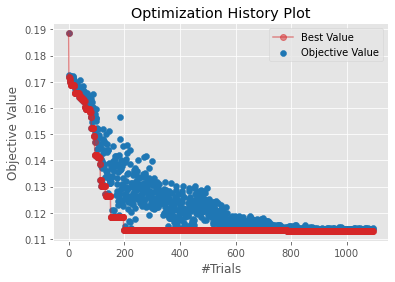

study_lgbm.best_value, study_lgbm.best_params

In [ ]:
0.11308438921545258,
 {'learning_rate': 0.01513309886250848,
  'max_depth': 7,
  'min_child_samples': 17,
  'min_split_gain': 0.0021084855144802364,
  'n_estimators': 2400,
  'num_leaves': 9,
  'reg_alpha': 0.15,
  'reg_lambda': 2.674,
  'subsample': 0.75}

In [38]:
%%time

params_lgbm_bayes = {
     'learning_rate': 0.01513,
      'max_depth': 7,
      'min_child_samples': 17,
      'min_split_gain': 0.0021,
      'n_estimators': 2400,
      'num_leaves': 9,
      'reg_alpha': 0.15,
      'reg_lambda': 2.674,
      'subsample': 0.75,
     'silent': True,
     'verbose': -1
}

params_lgbm_optuna = {
      'learning_rate': 0.01513309886250848,
      'max_depth': 7,
      'min_child_samples': 17,
      'min_split_gain': 0.0021084855144802364,
      'n_estimators': 2400,
      'num_leaves': 9,
      'reg_alpha': 0.15,
      'reg_lambda': 2.674,
      'subsample': 0.75
}


tuned_lgbm_booster_bayes = lgb.LGBMRegressor(**params_lgbm_bayes, n_jobs=4)

tuned_lgbm_booster_optuna = lgb.LGBMRegressor(**params_lgbm_optuna, n_jobs=4)

print('Tuned by Bayes\n')
display_cv_scores(*cv_rmse(tuned_lgbm_booster_bayes, X, y))

print('\n\nTuned by Optuna\n')
display_cv_scores(*cv_rmse(tuned_lgbm_booster_optuna, X, y))

Tuned by Bayes

RMSE CV: [0.11468011 0.1066075  0.11837512 0.11392208 0.11544796 0.11228134]  Mean RMSE: 0.1135524 Std RMSE: 0.003608
MAE CV: [0.07899229 0.07497634 0.07848738 0.07963841 0.07975917 0.07953855]  Mean MAE: 0.0785654 Std MAE: 0.001663
R2 CV: [0.88351376 0.9205913  0.88728875 0.89610428 0.90150921 0.89506619]  Mean R2: 0.8973456 Std R2: 0.0119506


Tuned by Optuna

RMSE CV: [0.11430106 0.1065922  0.11721432 0.11299703 0.1147576  0.11236108]  Mean RMSE: 0.1130372 Std RMSE: 0.003266
MAE CV: [0.07875523 0.07487827 0.07778408 0.07946696 0.07893424 0.07950739]  Mean MAE: 0.078221 Std MAE: 0.0016003
R2 CV: [0.88428254 0.92061409 0.88948844 0.89778469 0.90268361 0.89491708]  Mean R2: 0.8982951 Std R2: 0.0115685
Wall time: 53.5 s


#### GradientBoostingRegressor

In [23]:
%%time

gbr_params = {
    'loss': ['huber'],
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),        
    'n_estimators': Integer(25, 1500, prior='uniform'),
    'subsample':  Real(0.6, 1., prior='uniform'),   
    'max_depth': Integer(2, 10, prior='uniform'),
    'min_samples_split': Integer(2, 15, prior='uniform'),
    'min_samples_leaf': Integer(1, 13, prior='uniform'),
    'max_features': Real(0.7, 1., prior='uniform')
}

search_gbr = skopt.BayesSearchCV(estimator=GradientBoostingRegressor(),
                                search_spaces=gbr_params,
                                scoring='neg_mean_squared_error',
                                n_iter=150,
                                cv=kfolds,
                                random_state=11,
                                n_jobs=3,
                                 verbose=10
                                )

search_gbr_ = search_gbr.fit(X, y, callback=DeltaYStopper(delta=1e-3, n_best=15)) #, callback=DeltaYStopper(delta=1e-3, n_best=3))

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

In [42]:
-search_gbr.best_score_, np.sqrt(-search_gbr.best_score_)

(0.011747857945664691, 0.10838753593317219)

In [43]:
dict(search_gbr.best_params_)

{'learning_rate': 0.07876352809484428,
 'loss': 'huber',
 'max_depth': 2,
 'max_features': 1.0,
 'min_samples_leaf': 13,
 'min_samples_split': 15,
 'n_estimators': 611,
 'subsample': 0.6}

In [39]:
-search_gbr.best_score_, np.sqrt(-search_gbr.best_score_)

(0.011747857945664691, 0.10838753593317219)

In [40]:
dict(search_gbr.best_params_)

{'learning_rate': 0.07876352809484428,
 'loss': 'huber',
 'max_depth': 2,
 'max_features': 1.0,
 'min_samples_leaf': 13,
 'min_samples_split': 15,
 'n_estimators': 611,
 'subsample': 0.6}

##### Optuna (from Colab)

optuna.visualization.matplotlib.plot_optimization_history(study_gbr);

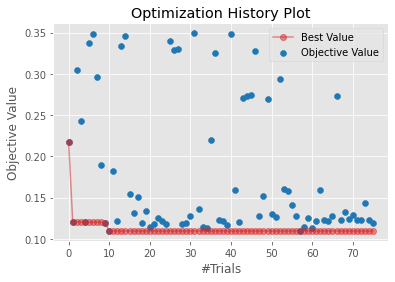

study_gbr.best_value, study_gbr.best_params

In [ ]:
0.10963405322004956,
 {'learning_rate': 0.04790194311532764,
  'max_depth': 2,
  'max_features': 0.73,
  'min_samples_split': 3,
  'n_estimators': 750}

In [57]:
%%time

params_gbr_bayes = {
     'learning_rate': 0.0788,
     'loss': 'huber',
     'max_depth': 2,
     'max_features': 1.0,
     'min_samples_leaf': 13,
     'min_samples_split': 15,
     'n_estimators': 650,
     'subsample': 0.6
}

params_gbr_optuna = {
    
}

tuned_gbr_booster_bayes = GradientBoostingRegressor(**params_gbr_bayes)

tuned_gbr_booster_optuna = GradientBoostingRegressor(**params_gbr_optuna)

print('Tuned by Bayes\n')
display_cv_scores(*cv_rmse(tuned_gbr_booster_bayes, X, y))

print('\n\nTuned by Optuna\n')
display_cv_scores(*cv_rmse(tuned_gbr_booster_optuna, X, y))

RMSE CV: [0.11036952 0.09723074 0.11373958 0.10972034 0.11247325 0.1105112 ]  Mean RMSE: 0.1090074 Std RMSE: 0.0054424
MAE CV: [0.07574145 0.0684004  0.07596492 0.07844661 0.07584687 0.07490233]  Mean MAE: 0.0748838 Std MAE: 0.0030973
R2 CV: [0.88991657 0.92863535 0.89581927 0.89779129 0.91221184 0.89232545]  Mean R2: 0.9027833 Std R2: 0.0135743
Wall time: 43.1 s


In [61]:
%%time

params_gbr_optuna = {
     'learning_rate': 0.0788,
     'loss': 'huber',
     'max_depth': 2,
     'max_features': 1.0,
     'min_samples_leaf': 13,
     'min_samples_split': 15,
     'n_estimators': 650,
     'subsample': 0.6
}

tuned_gbr_booster_optuna = GradientBoostingRegressor(**params_gbr_optuna)

display_cv_scores(*cv_rmse(tuned_gbr_booster_optuna, X, y))

RMSE CV: [0.10978782 0.09940199 0.11440334 0.11374686 0.11023879 0.10925331]  Mean RMSE: 0.109472 Std RMSE: 0.0049114
MAE CV: [0.07394926 0.07495725 0.07650401 0.0785949  0.07531729 0.07328613]  Mean MAE: 0.0754348 Std MAE: 0.0017414
R2 CV: [0.89474457 0.93600379 0.89672592 0.89686708 0.91370162 0.89765482]  Mean R2: 0.9059496 Std R2: 0.014862
Wall time: 53.3 s


In [54]:
tuned_gbr_booster_bayes = GradientBoostingRegressor()

display_cv_scores(*cv_rmse(tuned_gbr_booster_bayes, X, y))

RMSE CV: [0.11468941 0.11020292 0.12206815 0.11142015 0.11972659 0.12119072]  Mean RMSE: 0.1165497 Std RMSE: 0.0046929
MAE CV: [0.08107021 0.07850192 0.08288239 0.08097291 0.08412312 0.08623481]  Mean MAE: 0.0822976 Std MAE: 0.0024781
R2 CV: [0.88181888 0.91524524 0.87999154 0.90069505 0.89350574 0.87850924]  Mean R2: 0.8916276 Std R2: 0.0132114


## Compare models

In [17]:
alpha_l1_ = 0.00425

lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=alpha_l1_))

In [18]:
alpha_l2_ = 287.241

ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=alpha_l2_))

In [19]:
elastic_alpha = 0.07895
l1_ratio = 0.04211

elnet_reg = make_pipeline(StandardScaler(), ElasticNet(l1_ratio=l1_ratio, alpha=elastic_alpha))

In [20]:
tuned_param_svr = {
    'C': 9, 
    'gamma': 0.0001, 
    'kernel': 'rbf'
}

sv_reg = make_pipeline(StandardScaler(), SVR(**tuned_param_svr))

In [21]:
params_xgbr_optuna = {
      'colsample_bytree': 0.2,
      'learning_rate': 0.07,
      'max_depth': 2,
      'min_child_weight': 9,
      'n_estimators': 575,
      'reg_alpha': 0.316,
      'reg_lambda': 1.213,
      'subsample': 0.9
}

tuned_xgbr_booster_optuna = xgb.XGBRegressor(**params_xgbr_optuna, eval_metric='rmse', n_jobs=3)


In [22]:
params_lgbm_optuna = {
      'learning_rate': 0.01513309886250848,
      'max_depth': 7,
      'min_child_samples': 17,
      'min_split_gain': 0.0021084855144802364,
      'n_estimators': 2400,
      'num_leaves': 9,
      'reg_alpha': 0.15,
      'reg_lambda': 2.674,
      'subsample': 0.75
}



tuned_lgbm_booster_bayes = lgb.LGBMRegressor(**params_lgbm_optuna, n_jobs=3)

In [23]:
params_gbr_bayes = {
     'learning_rate': 0.0788,
     'loss': 'huber',
     'max_depth': 2,
     'max_features': 1.0,
     'min_samples_leaf': 13,
     'min_samples_split': 15,
     'n_estimators': 650,
     'subsample': 0.6
}

tuned_gbr_booster_bayes = GradientBoostingRegressor(**params_gbr_bayes)

### Stacking

##### Select MetaRegressor

In [24]:
models = {
    'lasso': lasso_reg,
    'ridge': ridge_reg,
    'elnet': elnet_reg,
    'svr': sv_reg,
    'xgbr': tuned_xgbr_booster_optuna,
    'lgbm': tuned_lgbm_booster_bayes,
    'gbr': tuned_gbr_booster_bayes   
}

stack_scores = {}

In [76]:
for name, model in models.items():
    stack_reg = StackingCVRegressor(regressors=(lasso_reg, 
                                                ridge_reg, 
                                                elnet_reg, 
                                                sv_reg, 
                                                tuned_xgbr_booster_optuna, 
                                                tuned_lgbm_booster_bayes, 
                                                tuned_gbr_booster_bayes),
                                meta_regressor=model,
                                use_features_in_secondary=True,
                                n_jobs=3,
                                verbose=10
                                )
    
    cv_stack_score = np.array(cv_rmse(stack_reg, np.array(X), np.array(y), kfolds=kfolds))
    
    stack_scores['meta_' + name] = cv_stack_score.mean(axis=1)[0]
    
    print('='*8, 'meta_' + name, '='*8)
    display_cv_scores(*cv_stack_score)
    print('-'*23, '\n')
    

======== meta_lasso ========
RMSE CV: [0.10388228 0.09855781 0.10724893 0.10904395 0.10842015 0.10726236]  Mean RMSE: 0.1057359 Std RMSE: 0.0035993
MAE CV: [0.07141611 0.07121682 0.07194094 0.07199803 0.07640183 0.07103677]  Mean MAE: 0.0723351 Std MAE: 0.0018524
R2 CV: [0.89968133 0.93347987 0.90252576 0.90374032 0.91229586 0.90271949]  Mean R2: 0.9090738 Std R2: 0.0115899
----------------------- 

======== meta_ridge ========
RMSE CV: [0.10658376 0.10199099 0.11535402 0.11681826 0.11309117 0.11137614]  Mean RMSE: 0.1108691 Std RMSE: 0.0051298
MAE CV: [0.07247964 0.07428178 0.07650649 0.07485034 0.0804363  0.07342273]  Mean MAE: 0.0753295 Std MAE: 0.0025997
R2 CV: [0.89966948 0.92831062 0.89272823 0.89210969 0.90543227 0.89713149]  Mean R2: 0.9025636 Std R2: 0.0123494
----------------------- 

======== meta_elnet ========
RMSE CV: [0.10466365 0.09960558 0.10966073 0.10963485 0.10973293 0.10812457]  Mean RMSE: 0.1069037 Std RMSE: 0.0037156
MAE CV: [0.06998801 0.07275447 0.0722786  0.07

In [77]:
print(f'Best meta regressor is {min(stack_scores, key=stack_scores.get)} with RMSE {min(stack_scores.values())}')

Best meta regressor is meta_lasso with RMSE 0.10573591357311292


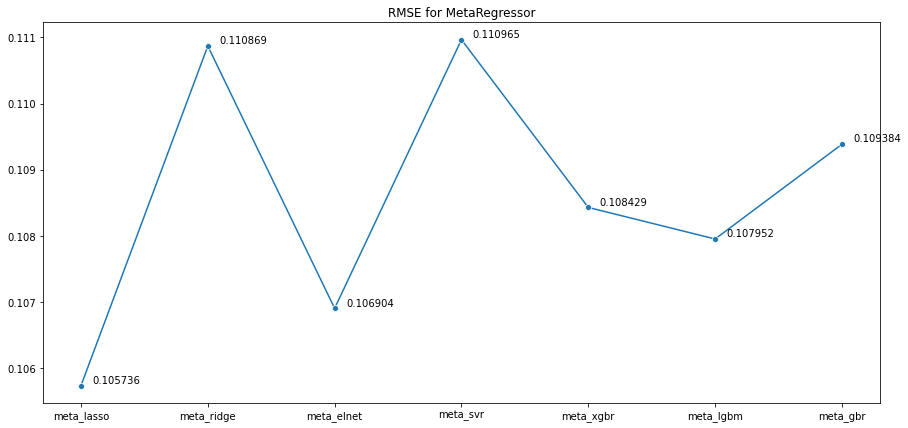

In [78]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x=stack_scores.keys(), y= stack_scores.values(), marker='o');
for i, score in enumerate(stack_scores.values()):
    ax.text(i+0.09, score+0.00004, f'{score:.6f}')
plt.title('RMSE for MetaRegressor');

In [27]:
tuned_stack_reg = StackingCVRegressor(regressors=(lasso_reg, 
                                                ridge_reg, 
                                                elnet_reg, 
                                                sv_reg, 
                                                tuned_xgbr_booster_optuna, 
                                                tuned_lgbm_booster_bayes, 
                                                tuned_gbr_booster_bayes),
                                meta_regressor=lasso_reg,
                                use_features_in_secondary=True,
                                n_jobs=3,
                                verbose=2)

models['stacked'] = tuned_stack_reg


In [ ]:
# display_cv_scores(*cv_rmse(tuned_stack_reg, np.array(X), np.array(y), kfolds=kfolds, verb=0))

##### Voting

In [29]:
models_arr = [(k, v) for k, v in models.items()]

voting_regr = VotingRegressor(models_arr,
                             n_jobs=4,
                             verbose=10)

display_cv_scores(*cv_rmse(voting_regr, np.array(X), np.array(y), kfolds=kfolds))

RMSE CV: [0.10371946 0.09677501 0.10931946 0.10805745 0.10784008 0.10411729]  Mean RMSE: 0.1049715 Std RMSE: 0.0042059
MAE CV: [0.06974189 0.07102425 0.07168253 0.07096369 0.0756425  0.07068612]  Mean MAE: 0.0716235 Std MAE: 0.0018872
R2 CV: [0.90460235 0.93475768 0.90344637 0.90606363 0.91358346 0.90881196]  Mean R2: 0.9118776 Std R2: 0.0107519


In [30]:
models['voting'] = voting_regr

In [31]:
models.keys()

dict_keys(['lasso', 'ridge', 'elnet', 'svr', 'xgbr', 'lgbm', 'gbr', 'stacked', 'voting'])

In [42]:
scores = {}

for name, model in models.items():
    
    cv_score = np.array(cv_rmse(model, np.array(X), np.array(y), kfolds=kfolds, verb=0))
    
    scores[name] = {
                    'mean': cv_score.mean(axis=1),
                    'std': cv_score.std(axis=1)
                }
    print('='*8, name, '='*8)
    print(f'RMSE = {cv_score.mean(axis=1)[0]}  |  MAE = {cv_score.mean(axis=1)[1]}  |  R2 = {cv_score.mean(axis=1)[2]}')
    print('-'*20, '\n')

======== lasso ========
RMSE = 0.10871496164479122  |  MAE = 0.0753898325369658  |  R2 = 0.9061999420024055
-------------------- 

======== ridge ========
RMSE = 0.1121911661437993  |  MAE = 0.07748140449828538  |  R2 = 0.8998620480310114
-------------------- 

======== elnet ========
RMSE = 0.10823601840778392  |  MAE = 0.07498848846830532  |  R2 = 0.9069769902059001
-------------------- 

======== svr ========
RMSE = 0.11180000048426787  |  MAE = 0.07832534316763241  |  R2 = 0.9004358025731407
-------------------- 

======== xgbr ========
RMSE = 0.10983643015990724  |  MAE = 0.07649416443359455  |  R2 = 0.9038787944224603
-------------------- 

======== lgbm ========
RMSE = 0.11303721532661448  |  MAE = 0.07822102739047686  |  R2 = 0.8982950735410867
-------------------- 

======== gbr ========
RMSE = 0.1099520679107804  |  MAE = 0.07549491589306272  |  R2 = 0.9046129902315304
-------------------- 

======== stacked ========
RMSE = 0.10658352308045987  |  MAE = 0.07263288130981017  |

## Forecasting Submissions

In [32]:
sample_sub = pd.read_csv('./data/sample_submission.csv')
sample_sub

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [159]:
test_df.head(5)

,2ndFloorY/N,PorchY/N,BsmtFinSF2_cat,LowQualFinSF_cat,EnclosedPorch_cat,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,MSZoning_FV,...,BsmtFinSF,OtherRooms,GarageSpaceForCar,WoodDeckOpenPorch,TotalPorchSF,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,
1461,0,1,1,0,0,0,1,0,0,0,...,0.251869,-0.440639,5.621140,-0.010178,0.258664,-0.612768,-1.216581,-1.442220,0.561781,-1.201794
1462,0,1,0,0,0,0,0,1,0,0,...,0.902142,-0.440639,0.640460,1.965756,-0.501474,0.589032,-0.133883,-0.194791,0.970361,0.126204
1463,1,1,0,0,0,0,0,0,0,0,...,0.626142,-0.440639,-0.205540,0.714559,-0.519573,-0.505796,0.905998,0.449232,0.908374,0.288127
1464,1,1,0,0,0,0,0,0,0,0,...,0.230960,0.461033,-0.277033,1.740130,-0.501474,-0.512373,0.039429,0.400297,0.257876,0.246570
1465,0,1,0,0,0,0,1,0,0,0,...,-0.477858,-0.440639,-0.062554,-0.406733,1.217885,0.474514,0.605668,-0.313657,-1.116906,0.001315


In [160]:
X.head(5)

,2ndFloorY/N,PorchY/N,BsmtFinSF2_cat,LowQualFinSF_cat,EnclosedPorch_cat,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,MSZoning_FV,...,BsmtFinSF,OtherRooms,GarageSpaceForCar,WoodDeckOpenPorch,TotalPorchSF,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,0,0,0,0,0,0,...,0.562915,1.333563,0.200358,-0.507130,-0.195467,-0.872968,-0.240149,0.651878,-0.237114,0.418300
2,0,0,0,0,0,0,0,0,0,0,...,1.193802,-0.469483,-0.296532,1.417162,-0.891971,0.497152,-0.330569,-0.329824,0.125468,-0.016393
3,1,1,0,0,0,0,0,0,0,0,...,0.052639,-0.469483,0.539147,-0.661398,-0.412410,-0.618474,1.618175,0.792398,0.576164,0.594309
4,1,1,0,0,1,0,0,0,0,0,...,-0.573609,0.432040,-0.477219,-0.718234,2.613386,-0.464582,0.532078,0.665079,0.110630,0.345734
5,1,1,0,0,0,0,0,0,0,0,...,0.444624,1.333563,0.253059,1.238536,0.067150,0.153748,0.507695,1.463149,1.249886,1.343907


In [33]:
tuned_stack_reg_ = voting_regr.fit(np.array(X), np.array(y))

In [34]:
y_pred = tuned_stack_reg_.predict(np.array(test_df))
y_pred.shape

(1459,)

In [36]:
sample_sub['SalePrice'] = np.exp(y_pred)
sample_sub

,Id,SalePrice
0,1461,122070.059433
1,1462,164081.173498
2,1463,179626.936483
3,1464,196433.022235
4,1465,192524.343937
...,...,...
1454,2915,95635.419140
1455,2916,96103.439277
1456,2917,168989.875069
1457,2918,122760.545276


In [40]:
sample_sub.to_csv('data/submit.csv', index=False)

In [128]:
y

Id
1       0.699150
2       0.311211
3       0.893486
4      -0.415006
5       1.206922
          ...   
1455    0.364640
1456    0.209194
1457    0.719203
1458    1.385707
1459   -0.372866
Name: SalePrice_log, Length: 1252, dtype: float64

In [125]:
test_df

,2ndFloorY/N,PorchY/N,BsmtFinSF2_cat,LowQualFinSF_cat,EnclosedPorch_cat,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,MSZoning_FV,...,BsmtFinSF,OtherRooms,GarageSpaceForCar,WoodDeckOpenPorch,TotalPorchSF,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,
1461,0,1,1,0,0,0,1,0,0,0,...,0.251869,-0.440639,7.664441,-0.010178,NaN,-0.612768,-1.216581,-1.442220,0.561781,-1.201794
1462,0,1,0,0,0,0,0,1,0,0,...,0.902142,-0.440639,0.662635,1.965756,NaN,0.589032,-0.133883,-0.194791,0.970361,0.126204
1463,1,1,0,0,0,0,0,0,0,0,...,0.626142,-0.440639,-0.526667,0.714559,NaN,-0.505796,0.905998,0.449232,0.908374,0.288127
1464,1,1,0,0,0,0,0,0,0,0,...,0.230960,0.461033,-0.627171,1.740130,NaN,-0.512373,0.039429,0.400297,0.257876,0.246570
1465,0,1,0,0,0,0,1,0,0,0,...,-0.477858,-0.440639,-0.325658,-0.406733,NaN,0.474514,0.605668,-0.313657,-1.116906,0.001315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1,1,0,0,0,0,0,0,0,0,...,-1.027767,-1.342310,NaN,-0.967378,NaN,-2.122697,-0.205891,-0.816275,-3.009500,-1.132891
2916,1,1,0,0,0,0,0,0,0,0,...,-0.500858,-0.440639,0.227116,-0.803287,NaN,-2.122697,-1.137370,-0.816275,-3.053203,-1.132891
2917,0,1,0,0,0,0,0,0,0,0,...,1.531505,-0.440639,0.260618,2.273427,NaN,0.338142,-1.341921,-0.455207,1.643426,-0.147407


In [127]:
X

,2ndFloorY/N,PorchY/N,BsmtFinSF2_cat,LowQualFinSF_cat,EnclosedPorch_cat,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,MSZoning_FV,...,BsmtFinSF,OtherRooms,GarageSpaceForCar,WoodDeckOpenPorch,TotalPorchSF,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,0,0,0,0,0,0,...,0.562915,1.333563,0.200358,-0.507130,-0.195467,-0.872968,-0.240149,0.651878,-0.237114,0.418300
2,0,0,0,0,0,0,0,0,0,0,...,1.193802,-0.469483,-0.296532,1.417162,-0.891971,0.497152,-0.330569,-0.329824,0.125468,-0.016393
3,1,1,0,0,0,0,0,0,0,0,...,0.052639,-0.469483,0.539147,-0.661398,-0.412410,-0.618474,1.618175,0.792398,0.576164,0.594309
4,1,1,0,0,1,0,0,0,0,0,...,-0.573609,0.432040,-0.477219,-0.718234,2.613386,-0.464582,0.532078,0.665079,0.110630,0.345734
5,1,1,0,0,0,0,0,0,0,0,...,0.444624,1.333563,0.253059,1.238536,0.067150,0.153748,0.507695,1.463149,1.249886,1.343907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,1,0,0,0,0,0,0,0,1,...,-0.123638,0.432040,-0.635321,-0.084923,0.398275,0.380578,-0.515901,-0.436551,-0.576016,-0.134355
1456,1,1,0,0,0,0,0,0,0,0,...,-1.074607,0.432040,-0.296532,-0.677637,-0.435247,-0.494088,0.298512,0.530576,-0.422257,0.393994
1457,0,0,1,0,0,0,0,0,0,0,...,1.135816,0.432040,-0.070673,1.831250,-0.891971,2.248877,1.589375,1.273944,1.025008,1.437425


In [56]:
scr = cv_rmse(lasso_reg, X, y, kfolds=kfolds)

In [99]:
scr

(array([0.2848823 , 0.27530303, 0.30639453, 0.30724993, 0.30951852,
        0.30286856]),
 array([0.1956968 , 0.20672758, 0.20500126, 0.20814133, 0.22282672,
        0.20704383]),
 array([0.90813502, 0.93232392, 0.90349962, 0.90342025, 0.90952742,
        0.90242708]))

In [92]:
display_cv_scores(*np.array(scr))

RMSE CV: [0.2848823  0.27530303 0.30639453 0.30724993 0.30951852 0.30286856]  Mean RMSE: 0.2977028 Std RMSE: 0.0129042
MAE CV: [0.1956968  0.20672758 0.20500126 0.20814133 0.22282672 0.20704383]  Mean MAE: 0.2075729 Std MAE: 0.0079755
R2 CV: [0.90813502 0.93232392 0.90349962 0.90342025 0.90952742 0.90242708]  Mean R2: 0.9098889 Std R2: 0.0103673


In [100]:
np.array(scr).mean(axis=1)

array([0.29770281, 0.20757292, 0.90988889])

In [67]:
scores['first'] = {'mean': np.array(scr).mean(axis=1), 'std': np.array(scr).std(axis=1)}

In [71]:
scores['first']['mean'][0]

0.29770281209690247

In [14]:
rmse, mae, r2 = [], [], []


alpha_l1_ = 0.0015
lasso_reg = Lasso(alpha=alpha_l1_).fit(X, y)

rmse_l1, mae_l1, r2_l1 = cv_rmse(lasso_reg, X, y)
rmse_l1, mae_l1, r2_l1 = rmse_l1.mean(), mae_l1.mean(), r2_l1.mean()
print('-'*7, 'LASSO', '-'*7)
print(f'RMSE = {rmse_l1}')
rmse.append(rmse_l1), mae.append(mae_l1), r2.append(r2_l1)


alpha_l2_ = 21.12
ridge_reg = Ridge(alpha=alpha_l2_).fit(X, y)

rmse_l2, mae_l2, r2_l2 = cv_rmse(ridge_reg, X, y)
rmse_l2, mae_l2, r2_l2 = rmse_l2.mean(), mae_l2.mean(), r2_l2.mean()
print('-'*7, 'RIDGE', '-'*7)
rmse.append(rmse_l2), mae.append(mae_l2), r2.append(r2_l2)





